# Introduction

This is my second blog post on the East Arlington Bus Priority Pilot.  You can read [my first post here](https://nbviewer.jupyter.org/github/thouis/ArlingtonBusData/blob/master/Busplot.ipynb), where I go through the intial cleaning and explorations of bus position data.  This post doesn't require much familiarity with my first post, though it might be of interest to some people.

In short, I've been grabbing MBTA bus location data every minute since September 4, for lines 77, 79, & 87, to try to help answer questions about the effectiveness of the pilot.

In this post, I'm going to try to use that data to answer three questions:
- what effect has the pilot had on bus speed?
- what effect has the pilot had on bus reliability?
- has the pilot made traffic worse for in other ways (for non-bus vehicles)?

(I've added some bits to this post to try to make it less full of uninteresting python code, and more focused on presenting the data.  If you want to see the nitty-gritty details, you can use the "Toggle code" button.)

**Edit**

I forgot to add a couple of important links relevant to the pilot:

[Public meeting on November 14th at Town Hall](https://www.arlingtonma.gov/Home/Components/News/News/8971/16?cftype=News)

[Survey on the Bus Pilot](https://docs.google.com/forms/d/e/1FAIpQLSdpgg548luBFFModjEM4OYVUdsEjpt1F-esUFmJyc4JOEO_MA/viewform)

Also, the MBTA and their partners have been doing their own data collection and analysis, some of which will be presented at the public meeting.  It's unlikely they are doing exactly the same sort of analysis that I am, so there're likely to be some differences in our results.  Fair warning: any glaring differences are more likely to be an error on my part than on theirs, as I did this for fun and to sate my own curiousity, rather than as a professional exercise.

In [2]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# load the data and plotting tools

import pandas
from bus_plot_tools import *

vehicles = pandas.read_csv('./valid_77_inbound_weekdays.csv')
vehicles.head()
vehicles = vehicles.set_index(pandas.DatetimeIndex(vehicles.time))

# get more accurate distance from Harvard
vehicles['dist_from_harvard'] = np.sqrt(vehicles.miles_north**2 + vehicles.miles_east**2)

# Overview of  behavior before and during the pilot

I still haven't found a great way to present bus position vs. time for multiple buses over multiple days.  I'm going to continue to use Marey plots (as I mentioned in my first post, these are named after [Étienne-Jules Marey](https://en.wikipedia.org/wiki/%C3%89tienne-Jules_Marey), with an introduction to them [on this page](https://ozagordi.github.io/2016/11/19/a-very-simple-plot/)).

### How to read Marey plots
These are plots of the 77 on weekdays, heading inbound between 7:00 and 9:30 a.m.

On these plots, time is vertical and location horizontal, so horizontal  stretches ( &mdash; ) along the lines are buses moving quickly, slanted lines ( \\ ) are slower moving buses, and vertical lines ( | ) are stopped buses.  I've added  blue lines showing every 15 minutes and particular locations relevant to the pilot along the vertical and horizontal axes, respectively.

I'm plotting **all** the buses for the month before the pilot and the three weeks of the pilot overlaid, in two separate plots.  This allows someone looking at the plots to get a general sense of where, when, and how buses move, and where bottlenecks exist.

For example, both before and during the pilot, buses at around 7 a.m. move quickly from before Lake Street all the way to Porter Square (long mostly horizontal lines).  You can also see the buses leaving the North Cambridge Carhouse (near Cameron Street) until about 7:15 a.m. to start their routes.

Before the pilot, the snarl of traffic between Lake Street and Route 16 during rush hour is... a literal snarl.  The slow-down of mixed car and bus traffic often extends past Lake, and the time for the bus to get through this stretch often takes ten minutes or more.

# Before the pilot

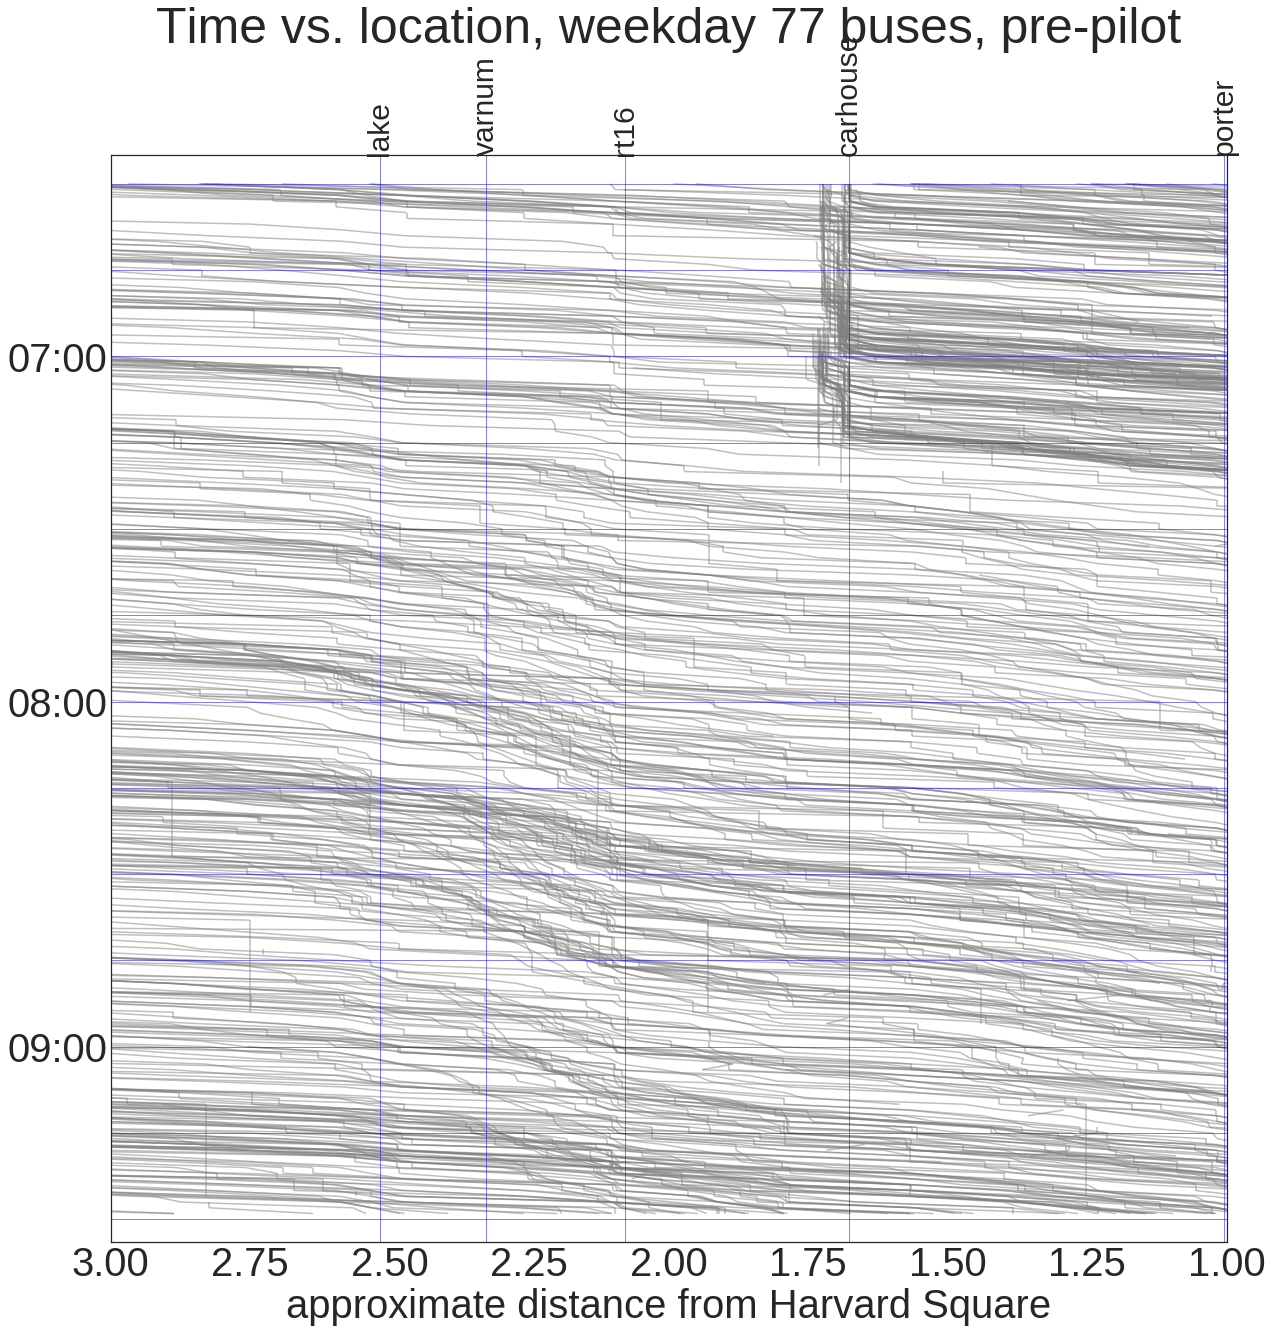

In [3]:
in_pilot_mask = ((vehicles.index.month == 10) & (vehicles.index.day >= 9)) | (vehicles.index.month == 11)
before_pilot = vehicles[~ in_pilot_mask]
during_pilot = vehicles[in_pilot_mask]

plot_marey(before_pilot)
title('Time vs. location, weekday 77 buses, pre-pilot\n\n');

# During the pilot

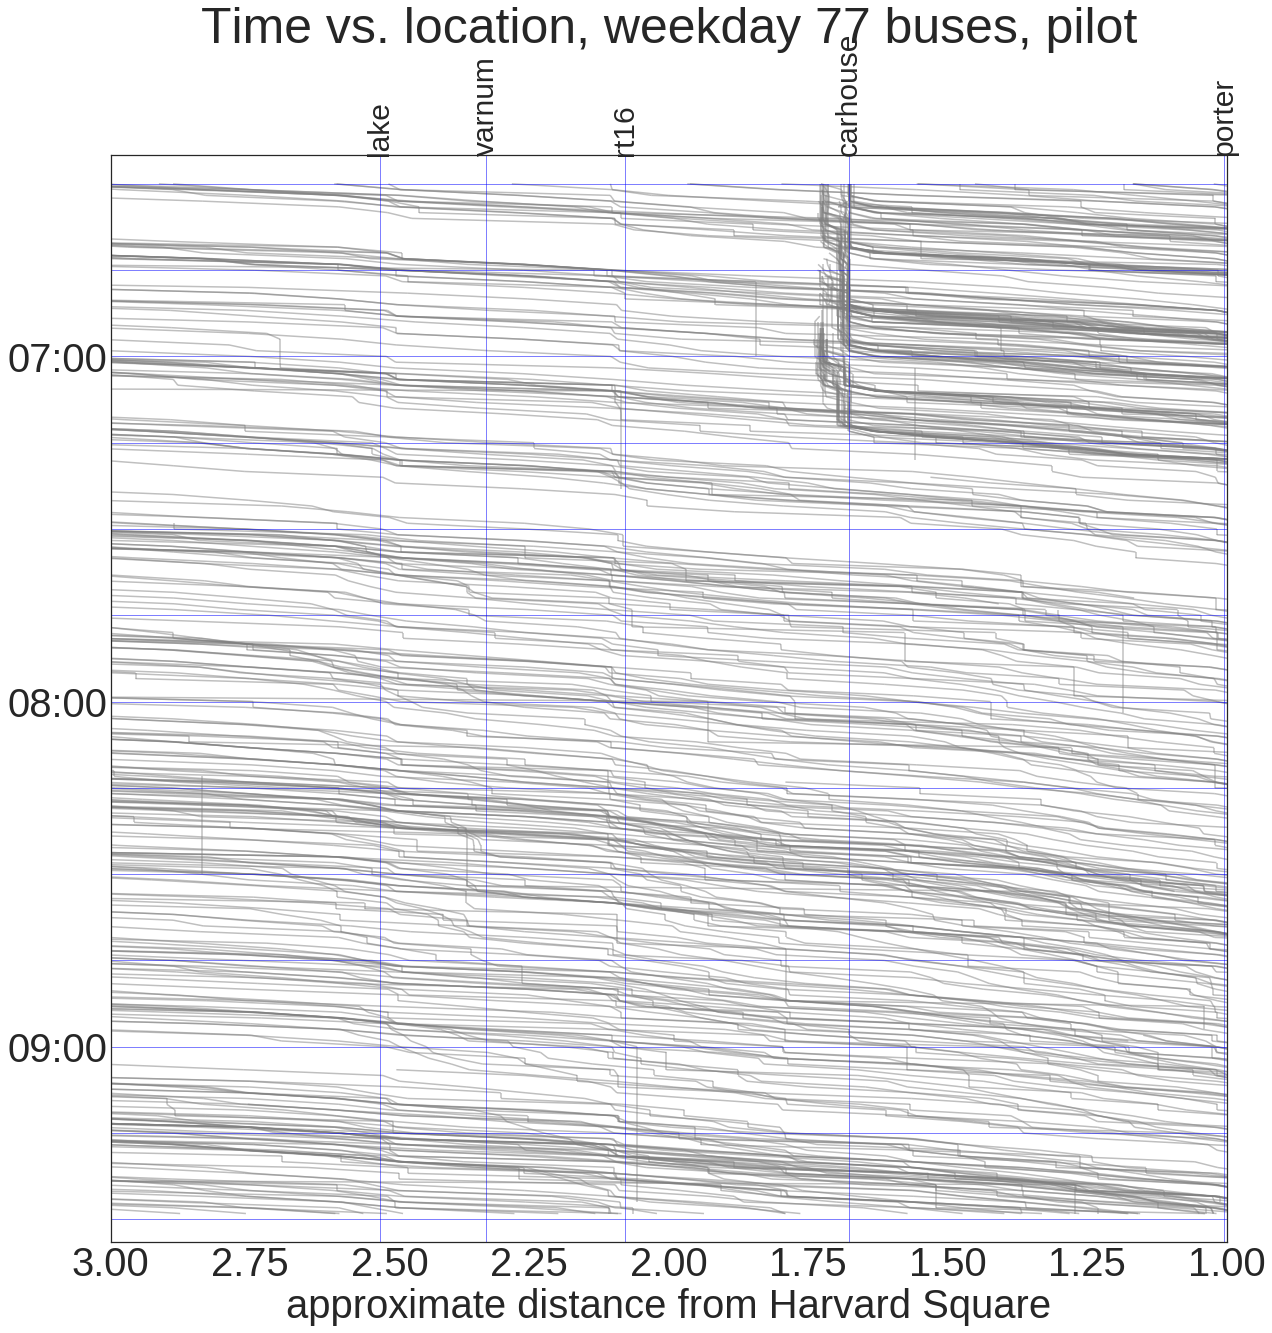

In [7]:
plot_marey(during_pilot)
title('Time vs. location, weekday 77 buses, pilot\n\n');

Compare the two plots above.

The difference is stark.  During the pilot, buses at 8:00 or 9:00 behave about the same as buses at 7:00.  Yes, rush hour is slightly slower, but buses are obviously skipping a lot of the traffic that we see before the pilot.

There are still a few times when the bus gets slowed down  between Lake and Varnum Streets.  We'll discuss that region a little more below.

# Rush hour time-on-bus plots & numbers

To put some numbers on the data above, I'm going look at how long it took buses to get between various points along the route before and during the pilot.  Here, I'm going to just look at three different regions:
- Arlington Center to Porter Square,
- Lake Street to Route 16, and
- Lake Street to Varnum Street.

The first is the most important, in terms of what most bus riders care about (how long does it take me to get from A to B?).  The second gives us an idea how much the pilot is having an effect.  The third can help answer the question, "is the pilot affecting other traffic negatively?"

(Because GPS positions are noisy, and I'm only collecting them once per minute, I do some normalization to get time estimates via average speed between samples.  Details are in the code for those that are curious.)

In [5]:
def dist(pt):
    return np.sqrt(pt[0]**2 + pt[1]**2)

def minutes_different(t1, t2):
    return (t2.hour - t1.hour) * 60 + (t2.minute - t1.minute) + (t2.second - t2.second) / 60

def sample_speeds_between_waypoints(vehicles, point1, point2, max_separation=60, max_speed=45, plot_lines=False):
    dist_difference = dist(locs_miles[point1]) - dist(locs_miles[point2])
    # point1 should be farther than point2
    assert dist_difference > 0
    
    results = []

    # Find all the buses that go from someplace farther than point1 from Harvard to closer than point2.
    # Return their last time before hitting point1, and their approximate time between the points.
    # (with some correction for where we actually get reports from the buses of their location).
    vehicles = vehicles.copy()  # allow us to modify the data we were passed
    vehicles['farther_than_1'] = vehicles.dist_from_harvard > dist(locs_miles[point1])
    vehicles['closer_than_2'] = vehicles.dist_from_harvard < dist(locs_miles[point2])
    
    # sample down to just vehicles outside the zone we're measuring
    vehicles = vehicles.query("farther_than_1 or closer_than_2")

    # find all the valid samples
    for veh, gr in vehicles.groupby('vehicle'):
        times = gr.index.time
        for idx in range(len(gr) - 1):
            weekday = gr.index.weekday[idx]
            if weekday >= 5:  # Monday == 0, Saturday = 5, Sunday = 6
                continue

            if gr.index.day[idx] == 8 and gr.index.month[idx] == 10:
                continue  # holiday on 10/08

            # only look for samples that straddle the zone we're measuring
            if not (gr.farther_than_1.iloc[idx] and gr.closer_than_2.iloc[idx + 1]):
                continue

            if gr.index.day[idx] != gr.index.day[idx + 1]:
                continue

            time_between = minutes_different(gr.index[idx], gr.index[idx + 1])
            if (time_between > max_separation):
                continue

            dist_between_samples = gr.dist_from_harvard.iloc[idx] - gr.dist_from_harvard.iloc[idx + 1]
            if dist_between_samples > 2 * dist_difference:
                continue  # some updates are stale, causing buses to seem to jump
            assert dist_between_samples > dist_difference, dist_between_samples
            approx_speed = dist_between_samples / time_between
            if approx_speed > max_speed / 60:
                continue  # more jumping effects?  unrealistic speeds, in any case.
            results.append((times[idx], time_between * dist_difference / dist_between_samples))
            if plot_lines:
                plot((gr.dist_from_harvard.iloc[idx], gr.dist_from_harvard.iloc[idx + 1]),
                     (times[idx], times[idx + 1]))
    return results

def limit_to_rush_hour(samples):
    for timestamp, time_to_traverse in samples:
        if timestamp.hour == 8 or (timestamp.hour == 7 and timestamp.minute > 30):
            yield time_to_traverse

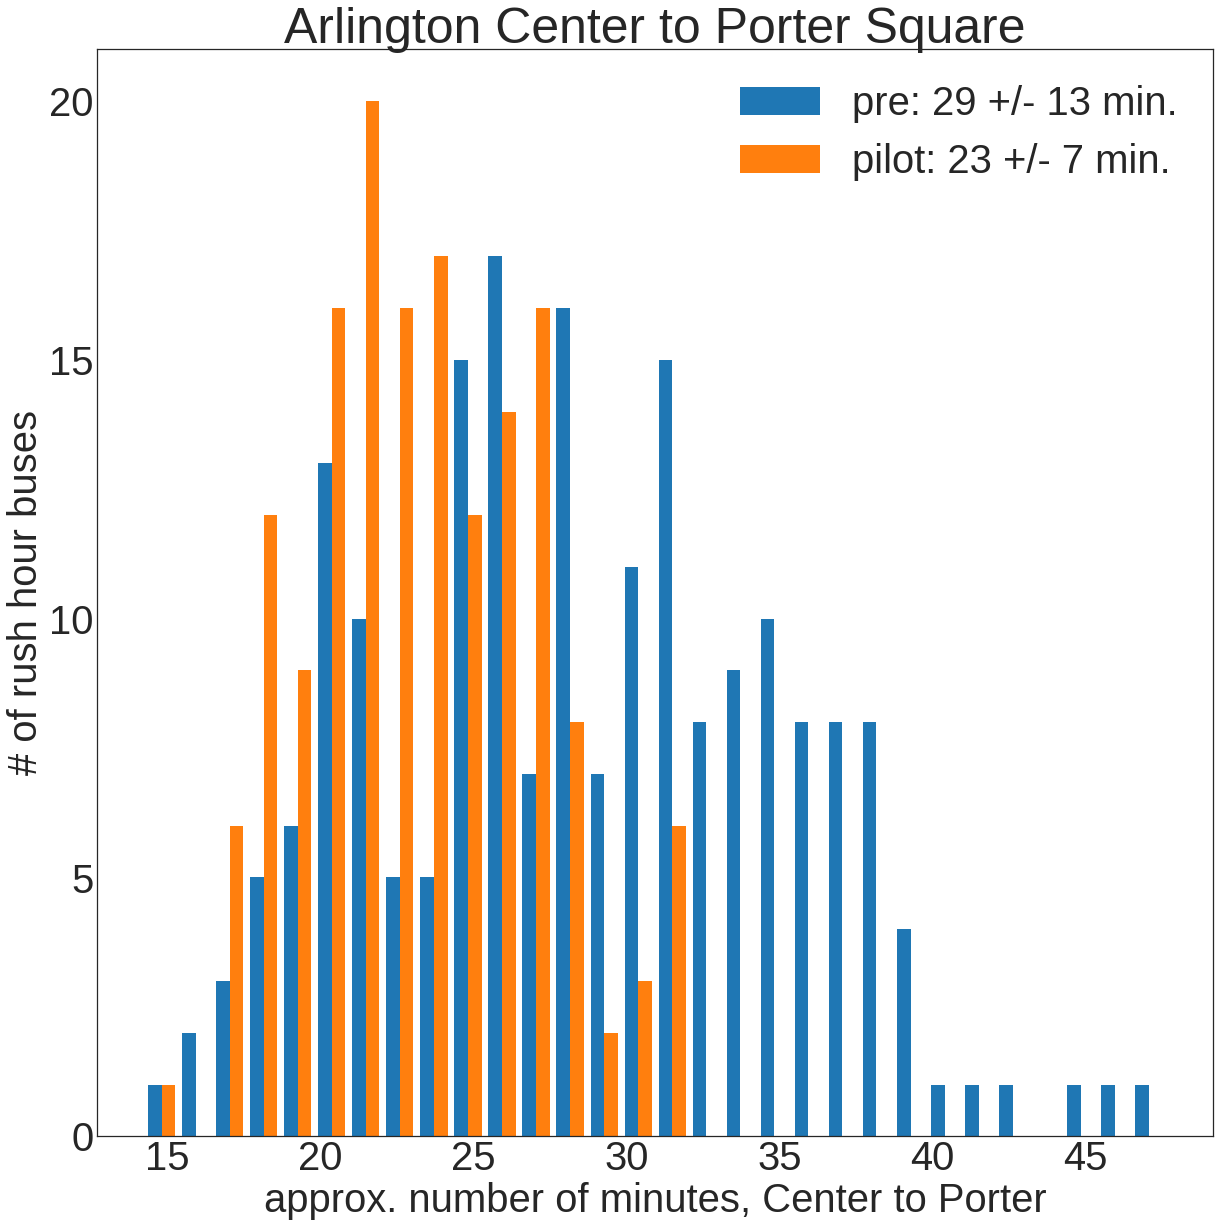

In [11]:
before_pilot_samples = sample_speeds_between_waypoints(before_pilot, 'center', 'porter')
during_pilot_samples = sample_speeds_between_waypoints(during_pilot, 'center', 'porter')

pre_pilot_rush_hour = list(limit_to_rush_hour(before_pilot_samples))
during_pilot_rush_hour = list(limit_to_rush_hour(during_pilot_samples))

pre_mean = mean(pre_pilot_rush_hour)
pilot_mean = mean(during_pilot_rush_hour)
pre_pm = 2 * std(pre_pilot_rush_hour)
pilot_pm = 2 * std(during_pilot_rush_hour)

prel = "pre: {} +/- {} min.".format(int(np.round(pre_mean)), int(np.round(pre_pm)))
pill = "pilot: {} +/- {} min.".format(int(np.round(pilot_mean)), int(np.round(pilot_pm)))


hist([pre_pilot_rush_hour, during_pilot_rush_hour], bins=30, label=[prel, pill])
title('Arlington Center to Porter Square')
xlabel('Approx. number of minutes, Center to Porter')
ylabel ('# of rush hour buses (multiple days)')

yticks([0,5,10,15,20])

legend();


# Result #1: The pilot has trimmed travel time by about 5 minutes.

To me, this is pretty impressive.  The pilot region is only about half a mile long, but fixing it has improved travel times significantly.  That change affects hundreds of people each day.

However, I think this might be more important:

# Result #2: The pilot has made the bus much more reliable and consistent.

Compare the worst-case behavior of the buses before and during the pilot.  Before the pilot, someone getting on the bus at the Center would expect to get to Porter about 30 minutes later, but they might not get there for **45 minutes**, or 50% longer than they originally expected.  That lack of reliability makes the bus a difficult proposition for many people.

The worst case during the pilot is about the same as the average case before the pilot.  The worst case is only about 30% more than the average case (and < 25%, if you compare to the pre-pilot average time).  In fact, only 9 times during the pilot, so far, has the bus taken more than 30 minutes to make this trip.  Five of those nine were on the first day.  

During the pilot, the bus has been much more consistent.  It's a low-risk trip: regardless of what time you get on the bus at the Center, you know you'll be to Porter within 30 minutes, and usually in about 23 minutes.

# How much of the change can we attribute to the pilot?

If we look at just the pilot region, between Lake and Route 16, we can see how much of these changes are (probably) from the pilot.

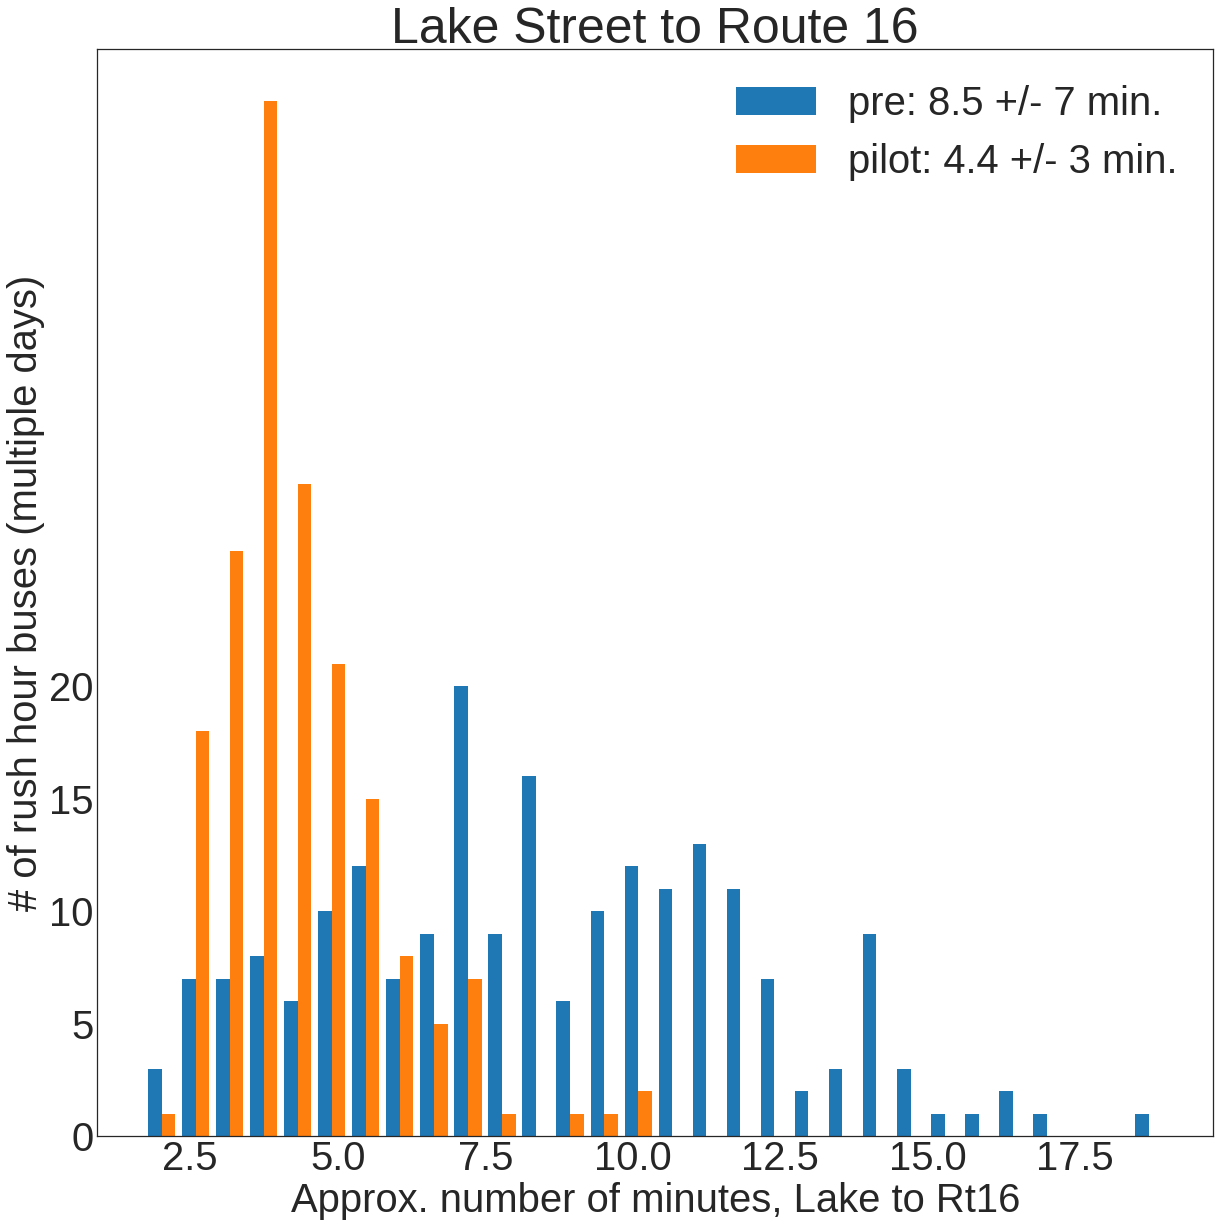

In [15]:
before_pilot_samples = sample_speeds_between_waypoints(before_pilot, 'lake', 'rt16')
during_pilot_samples = sample_speeds_between_waypoints(during_pilot, 'lake', 'rt16')

pre_pilot_rush_hour = list(limit_to_rush_hour(before_pilot_samples))
during_pilot_rush_hour = list(limit_to_rush_hour(during_pilot_samples))

pre_mean = mean(pre_pilot_rush_hour)
pilot_mean = mean(during_pilot_rush_hour)
pre_pm = 2 * std(pre_pilot_rush_hour)
pilot_pm = 2 * std(during_pilot_rush_hour)

prel = "pre: {:.1f} +/- {} min.".format(pre_mean, int(np.round(pre_pm)))
pill = "pilot: {:.1f} +/- {} min.".format(pilot_mean, int(np.round(pilot_pm)))


hist([pre_pilot_rush_hour, during_pilot_rush_hour], bins=30, label=[prel, pill])
title('Lake Street to Route 16')
xlabel('Approx. number of minutes, Lake to Rt16')
ylabel ('# of rush hour buses (multiple days)')

yticks([0,5,10,15,20])

legend();


# Most of the improvements are concentrated in the pilot region.

A good fraction the improvements in time and variability are concentrated in the pilot region.

There's a bit of improvement in speed from Arlington Center to Porter that doesn't show up in Lake to Route 16.  However, that speed improvement does show up if we look at the Center to Route 16.  That extra improvement might be from the changes in and around the Lake Street intersection that aren't well captured in the plot above.

# What about non-bus traffic?

Finally, let's look at the short region between Lake Street and Varnum.  This is an interesting place to examine, because:
- Bus and car traffic aren't separated, so we can expect the bus speed and the car speed to be about the same in this region, and
- traffic often backs up into this region (cf. the plot at the top of the page).

If the pilot were making traffic worse for non-bus vehicles, we'd expect more backups to extend to Lake, and to show up in the Lake-to-Varnum stretch of road.

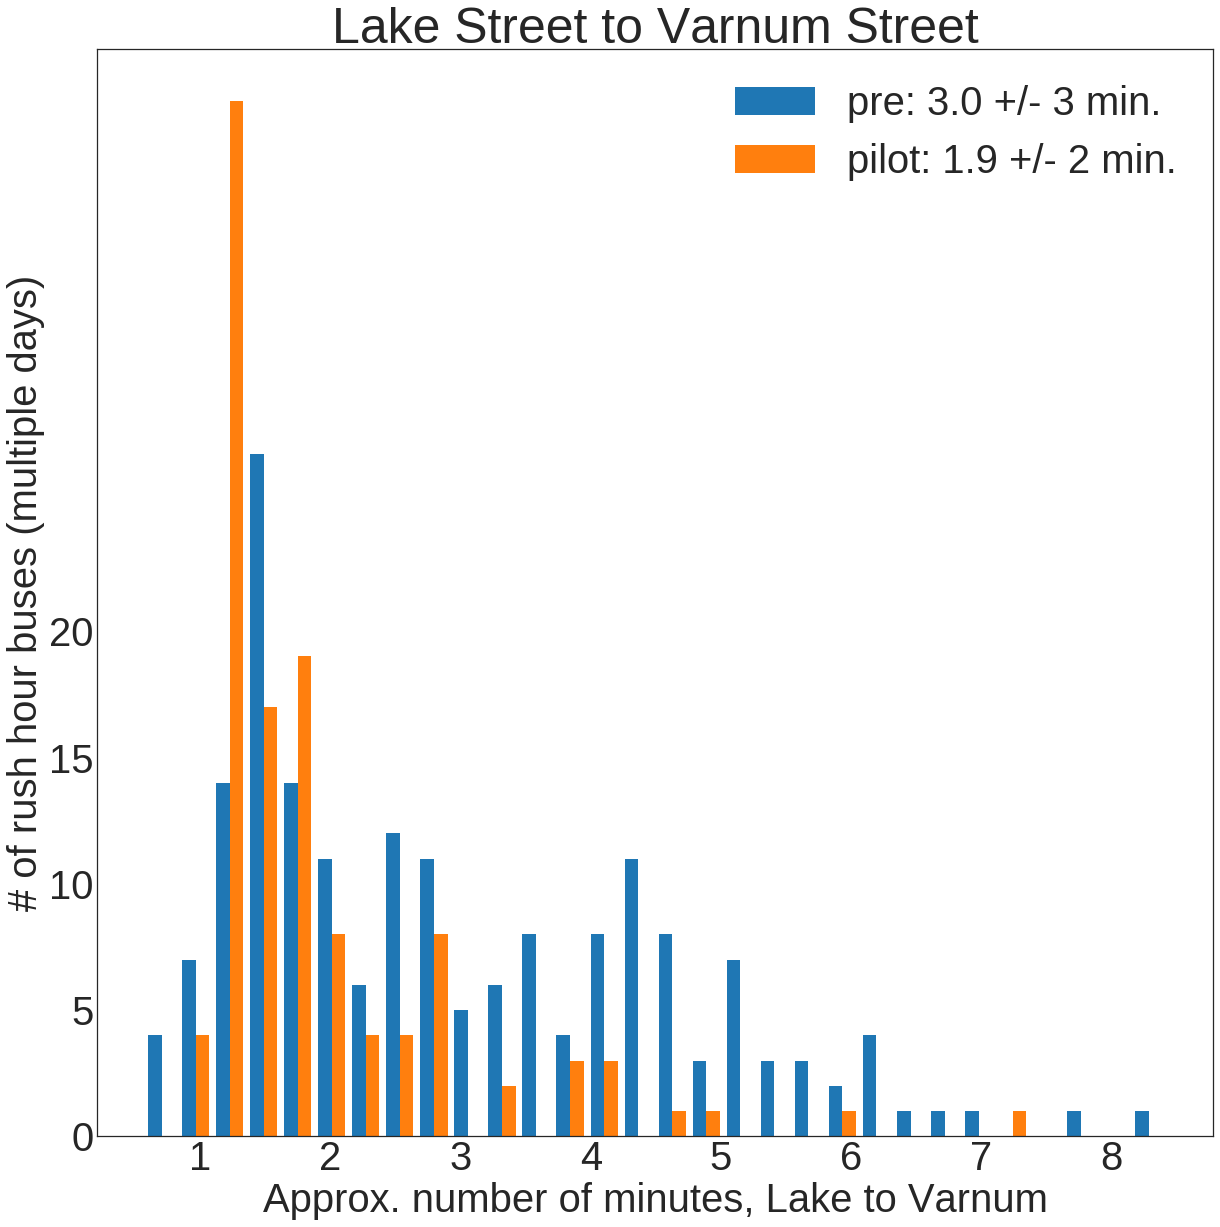

In [16]:
before_pilot_samples = sample_speeds_between_waypoints(before_pilot, 'lake', 'varnum')
during_pilot_samples = sample_speeds_between_waypoints(during_pilot, 'lake', 'varnum')

pre_pilot_rush_hour = list(limit_to_rush_hour(before_pilot_samples))
during_pilot_rush_hour = list(limit_to_rush_hour(during_pilot_samples))

pre_mean = mean(pre_pilot_rush_hour)
pilot_mean = mean(during_pilot_rush_hour)
pre_pm = 2 * std(pre_pilot_rush_hour)
pilot_pm = 2 * std(during_pilot_rush_hour)

prel = "pre: {:.1f} +/- {} min.".format(pre_mean, int(np.round(pre_pm)))
pill = "pilot: {:.1f} +/- {} min.".format(pilot_mean, int(np.round(pilot_pm)))


hist([pre_pilot_rush_hour, during_pilot_rush_hour], bins=30, label=[prel, pill])
title('Lake Street to Varnum Street')
xlabel('Approx. number of minutes, Lake to Varnum')
ylabel ('# of rush hour buses (multiple days)')

yticks([0,5,10,15,20])

legend();


# Result #3: The pilot has not made other traffic worse.

Buses are moving from Lake Street to Varnum street faster during the pilot.  Some of this is due to changes around Lake Street (bus priority at the light, and moving the stop to the other side of Lake).

However, traiffic in this stretch is not significantly worse.  In fact, all but **one** of the trips taking more than 4 minutes during the pilot was on its first day.  (I've put the plot with the first day of the pilot removed at the end of this post.)

This agrees with what I've heard from a neighbor that has to drive (he runs a construction business and has to take his truck into Cambridge every day).  Traffic is not worse (and he thought it was much better, overall).

# Summary (and opinion section)

Overall, I think the pilot's been a great success.  It's sped up the buses significantly, made them much more reliable, and hasn't adversely affected other traffic.

I'm glad the town undertook this experiment.  It's important for us to think about how we're going to deal with growth in our town, and how we'll manage increasing demands on our infrastructure, and limit our environmental impact.  Also, reducing the amount of traffic in town makes it a nicer place to live, overall.  The bus pilot has helped in all of these areas.





# Postscript

Lake to Varnum, and Arlington Center to Porter, removing the first day of the pilot.

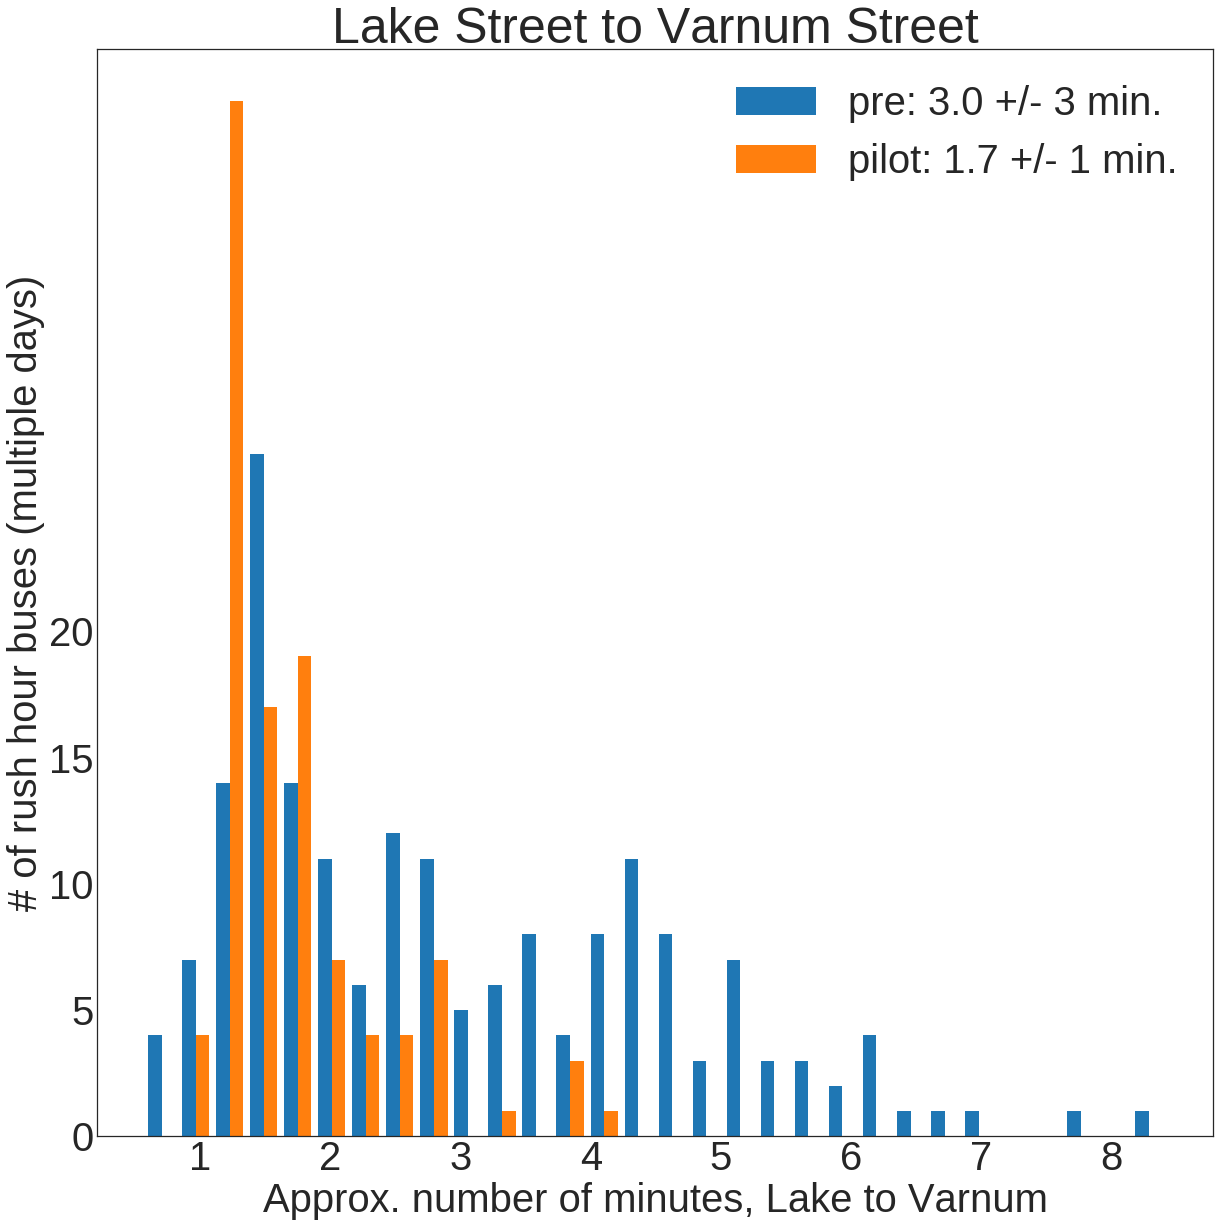

In [17]:
after_pilot_mask = ((vehicles.index.month == 10) & (vehicles.index.day > 9)) | (vehicles.index.month == 11)
after_pilot = vehicles[after_pilot_mask]

before_pilot_samples = sample_speeds_between_waypoints(before_pilot, 'lake', 'varnum')
during_pilot_samples = sample_speeds_between_waypoints(after_pilot, 'lake', 'varnum')

pre_pilot_rush_hour = list(limit_to_rush_hour(before_pilot_samples))
during_pilot_rush_hour = list(limit_to_rush_hour(during_pilot_samples))

pre_mean = mean(pre_pilot_rush_hour)
pilot_mean = mean(during_pilot_rush_hour)
pre_pm = 2 * std(pre_pilot_rush_hour)
pilot_pm = 2 * std(during_pilot_rush_hour)

prel = "pre: {:.1f} +/- {} min.".format(pre_mean, int(np.round(pre_pm)))
pill = "pilot: {:.1f} +/- {} min.".format(pilot_mean, int(np.round(pilot_pm)))


hist([pre_pilot_rush_hour, during_pilot_rush_hour], bins=30, label=[prel, pill])
title('Lake Street to Varnum Street')
xlabel('Approx. number of minutes, Lake to Varnum')
ylabel ('# of rush hour buses (multiple days)')

yticks([0,5,10,15,20])

legend();


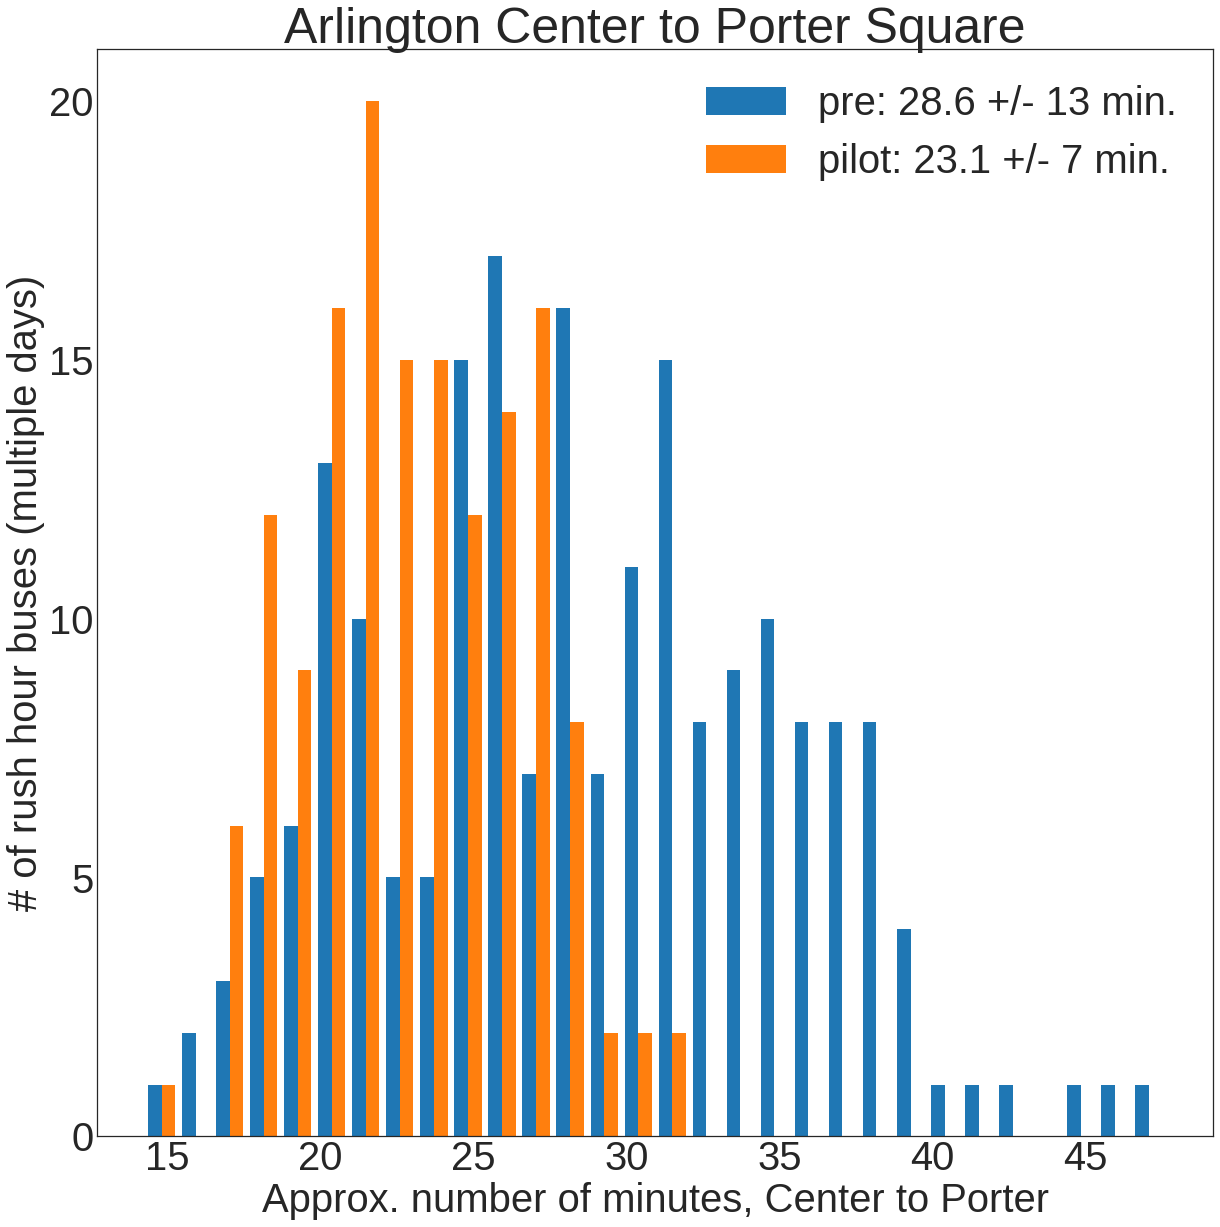

In [20]:
after_pilot_mask = ((vehicles.index.month == 10) & (vehicles.index.day > 9)) | (vehicles.index.month == 11)
after_pilot = vehicles[after_pilot_mask]

before_pilot_samples = sample_speeds_between_waypoints(before_pilot, 'center', 'porter')
during_pilot_samples = sample_speeds_between_waypoints(after_pilot, 'center', 'porter')

pre_pilot_rush_hour = list(limit_to_rush_hour(before_pilot_samples))
during_pilot_rush_hour = list(limit_to_rush_hour(during_pilot_samples))

pre_mean = mean(pre_pilot_rush_hour)
pilot_mean = mean(during_pilot_rush_hour)
pre_pm = 2 * std(pre_pilot_rush_hour)
pilot_pm = 2 * std(during_pilot_rush_hour)

prel = "pre: {:.1f} +/- {} min.".format(pre_mean, int(np.round(pre_pm)))
pill = "pilot: {:.1f} +/- {} min.".format(pilot_mean, int(np.round(pilot_pm)))


hist([pre_pilot_rush_hour, during_pilot_rush_hour], bins=30, label=[prel, pill])
title('Arlington Center to Porter Square')
xlabel('Approx. number of minutes, Center to Porter')
ylabel ('# of rush hour buses (multiple days)')

yticks([0,5,10,15,20])

legend();
